# Metrics and Regression Evaluation

Now we will evaluate the results of a random forest regressor trained on the Boston housing data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.datasets import load_boston
from sklearn import model_selection, preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor

In [2]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
rfr = RandomForestRegressor(random_state=42, n_estimators=100)
rfr.fit(X_train, y_train)
y_test_pred = rfr.predict(X_test)

## Metrics

Metric functions ending in loss or error should be minimized. Functions ending in score should be maximized.

the *coefficient of determination* ($r^2$) is a common regression metric. This value is typically between 0 and 1. It represents the percent of the variance of the gtarget that the features contribute. Higher values are better, but in general it is difficult to evaluate the model from this metric alone. We use this number in combination with other metrics or visualizations to evaluate a model.

In [5]:
rfr.score(X_test, y_test)

0.8721182042634867

*Mean absolute error* expresses the average absolute model prediction error. A perfect model would score 0, but this metric has no upper bounds, unlike the coefficient of determination. However, since it is in units of the target, it is more interpretable. If you want to ignore outliers, this is a good metric to use. 

This measure does NOT indicate how bad a model is, but can be used to compare two models. If you have two models, the model with the lower score is better. 

In [20]:
metrics.mean_absolute_error(y_test, y_test_pred)

2.0839802631578945

*Root mean squared error* also measures model error in terms of the target. However, since it averages the sqare of errors before taking the square root, it penalizes large errors. If you want to penalize large errors, this is a good metric to use. 

as with mean absolute error, this measure cannot indicate how bad a model is, but can be used to compare two models. If you assume that errors are normally distributed, this is a good choice.

The result tells us if we sqare the errors and average them, the result will be around 9.5:

In [21]:
metrics.mean_squared_error(y_test, y_test_pred)

9.52886846710526

The *mean squared logarithmic error* penalizes underprediction more than over prediction. If you have targets that experience exponential growth (population, stock, etc.), this is a good metric.

if you take the log of the error and then square it, the average of these results will be 0.021:

In [22]:
metrics.mean_squared_log_error(y_test, y_test_pred)

0.021282630617764333

## Residuals Plot

Good models (with appropriate R2 scores) will exhibit *homoscedasticity*. This means the variance is the same for all values of targets regardless of the input. Plotted, this looks like randomly distributed values in a residuals plot. If there are patters, the model or the data are problematic.

Residuals plots also show outliers, which can have a big impact on model fitting.


In [23]:
from yellowbrick.regressor import ResidualsPlot

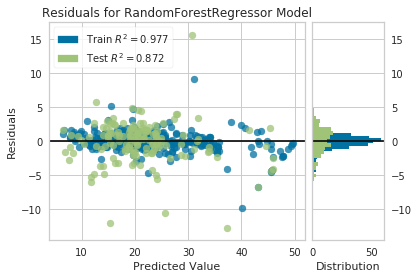

In [26]:
fig, ax = plt.subplots(figsize=(6,4))
rpv = ResidualsPlot(rfr)
rpv.fit(X_train, y_train)
rpv.score(X_test, y_test)
rpv.poof();

## Heteroscedasticity

The statsmodel package includes the *Breusch-Pagan* test for heteroscedasticity. This means that variance of the residuals varies over the prediction values. In the *Breusch-Pagan* test, if the p-values are significant (p-value less than 0.05), the null hypothesis of homoscedasticy is rejected. This indicates that residuals are heteroscedastic, and the predictions are biased. 

Test confirm heteroscedasticity:

In [30]:
import statsmodels.stats.api as sms
resid = y_test - y_test_pred

In [31]:
hb = sms.het_breuschpagan(resid, X_test)

In [32]:
labels = ["Lagrange multiplier statistic", "p-value","f-value","f p-value"]

In [34]:
for name, num in zip(labels, hb):
    print(f"{name:10}: {num:.2}")

Lagrange multiplier statistic: 3.6e+01
p-value   : 0.00036
f-value   : 3.3
f p-value : 0.00022


## Normal Residuals

The scipy library includes a *probability plot* and the *Kolmogorov-Smirnov* test, both of which measure whether the residuals are normal. 



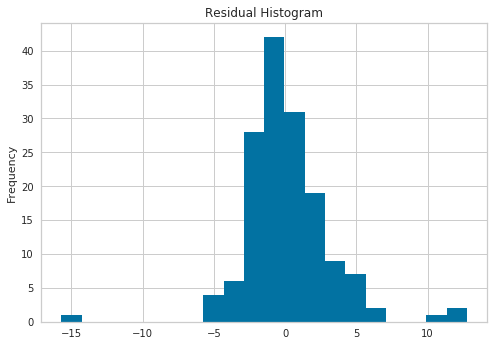

In [43]:
pd.Series(resid, name="residuals").plot(kind="hist", 
                                        bins=20,
                                       title="Residual Histogram");

If the samples plotted against the quantiles line up, the residuals are normal. We sse that this case fails:

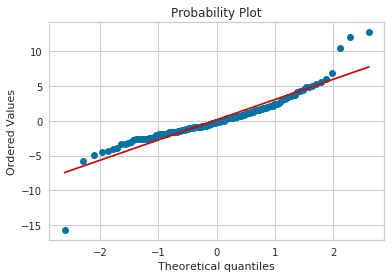

In [42]:
from scipy import stats
fig, ax = plt.subplots(figsize=(6,4))
_ = stats.probplot(resid, plot=ax)

The Kolmoggorov-Smirnov test can evaluate whether a distribution is normal. If the p-value is significant (<0.05), then the values are not normal.

This fails as well, which tells us the residuals are not normal:

In [44]:
stats.kstest(resid, cdf="norm")

KstestResult(statistic=0.1962230021010155, pvalue=1.3283596864962378e-05)

## Prediction Error Plot

A prediction error plot shows the real targets against the predicted values. For a perfect model these points would line up in a 45-degree line. 

As our model seems to predict lower values for the high end of y, the model has some performance issues. This is also evident in the residuals plot:

In [45]:
from yellowbrick.regressor import PredictionError

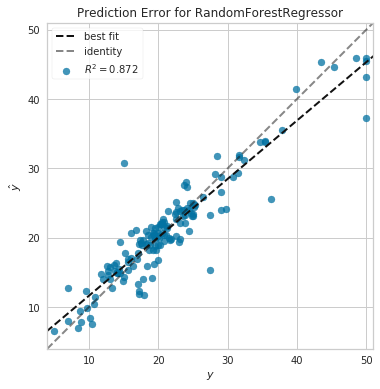

In [47]:
fig, ax = plt.subplots(figsize=(6,6))
pev = PredictionError(rfr)
pev.fit(X_train, y_train)
pev.score(X_test, y_test)
pev.poof();